In this notebook we will try to replicate the process described in this [article](https://www.mbtabackontrack.com/blog/61-dedicated-bus-lanes)

Notes of this article can be found [here](https://paper.dropbox.com/doc/Speeds-data-for-prioritizing-BRT--AukRpD4mNEpo02CermsgH43~Ag-YtczDJpiMJF4HcEX7LAqt)

In [1]:
import pandas as pd
import geopandas as gpd
import folium as fm
import keplergl as kp

# RIDESHIP DATA

In [2]:
# Import data by line

load_by_window = gpd.read_file(r"C:\Users\santi\Google Drive\Master\Python\alightings from boardings\3- Load\Output\load_by_window.geojson")
load_by_window.head(2)

,agency_route_id,remix_route_id,route_short_name,route_long_name,direction_id,service_window,stop_sequence,start_stop_id,end_stop_id,start_stop_name,end_stop_name,segment_id,segment_name,total_boardings,total_alightings,load,geometry
0,1,7ab9ac7,1,1 - Harvard - Dudley via Massachusetts Avenue,0,03:00 - 06:00,1.0,110,2168,Massachusetts Ave @ Holyoke St,Massachusetts Ave @ Johnston Gate,110_2168,Massachusetts Ave @ Holyoke St - Massachusetts...,5.1,0.0,5.1,"LINESTRING (-71.11817 42.37318, -71.11846 42.3..."
1,1,7ab9ac7,1,1 - Harvard - Dudley via Massachusetts Avenue,0,03:00 - 06:00,2.0,2168,2166,Massachusetts Ave @ Johnston Gate,Quincy St @ Broadway opp Fogg Museum,2168_2166,Massachusetts Ave @ Johnston Gate - Quincy St ...,2.6,0.0,7.7,"LINESTRING (-71.11858 42.37515, -71.11850 42.3..."


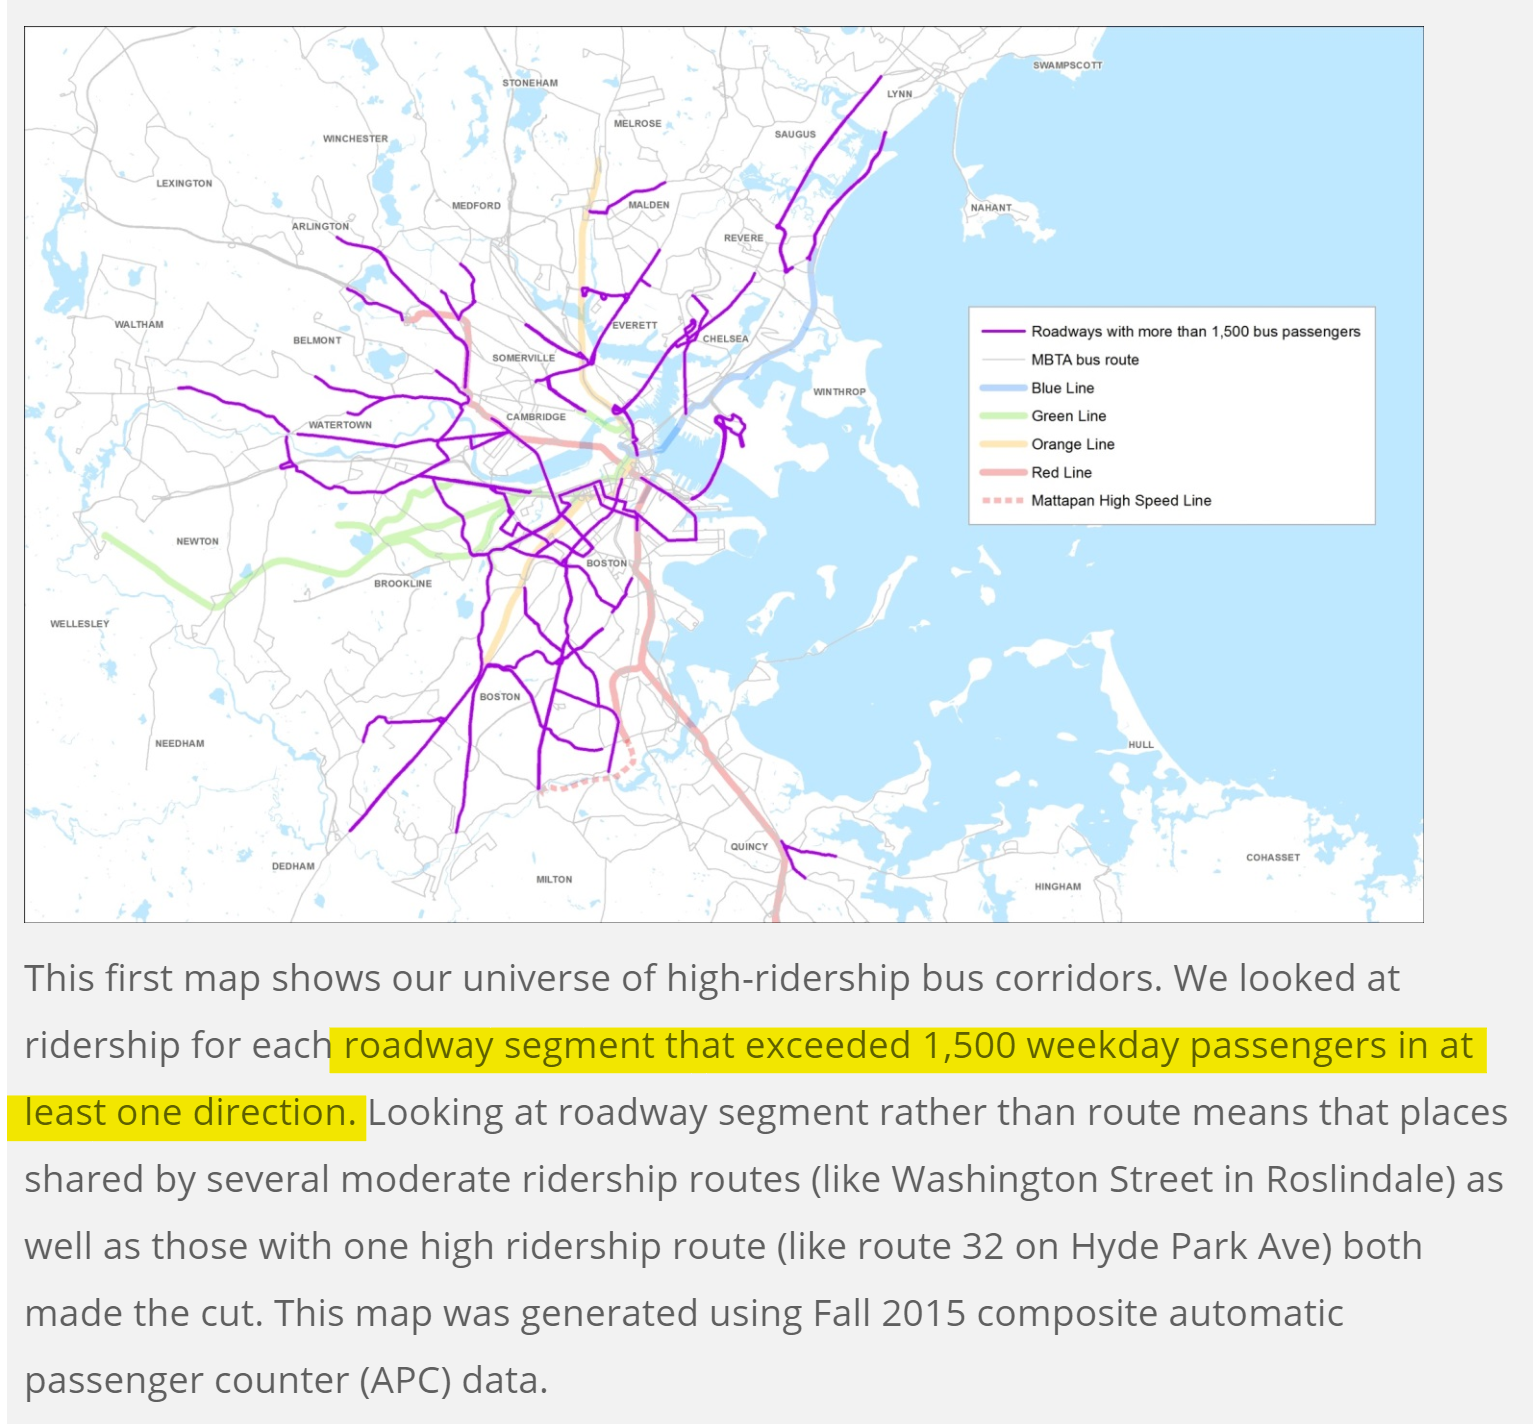

In [3]:
from IPython.display import Image
Image(r"C:\Users\santi\Google Drive\Master\Python\INRIX\img\ridership_by_segment.png")

In [4]:
# Look for corridors with high Ridership
# Information now is by route, window, and segment
# We need it by segment

segment_ridership = load_by_window.pivot_table('total_boardings', index=['segment_id', 'segment_name'], aggfunc='sum').reset_index().sort_values(by='total_boardings', ascending=False)
segment_ridership.head()

,segment_id,segment_name,total_boardings
159,1475_1478,Hancock St @ Bowdoin St - Hancock St @ Rowell St,12206.6
165,1481_11482,Dudley St @ Belden St - Dudley St @ Uphams Cor...,10775.0
140,13_2905,Andrew - Boston St @ Ellery St,5894.6
167,1484_1485,Dudley St @ E Cottage St - Dudley St @ Langdon St,5660.0
137,13_11241,Andrew - South Bay Mall @ Target,5582.1


In [5]:
print('# segments with ridership > 1000 passengers/day = ' + str(len(segment_ridership.loc[segment_ridership.total_boardings>1000,:])))

# segments with ridership > 1000 passengers/day = 34


In [6]:
# Bring the geometry to the segments

segment_ridership = pd.merge(segment_ridership, load_by_window.loc[:,['segment_id', 'geometry']], how='left')
segment_ridership.drop_duplicates(subset=['segment_id', 'total_boardings', 'segment_name'], keep='first', inplace=True)

data_segment = segment_ridership.drop('geometry', axis=1)
segment_ridership = gpd.GeoDataFrame(data=data_segment, geometry = segment_ridership.geometry)
segment_ridership.head(1)

,segment_id,segment_name,total_boardings,geometry
0,1475_1478,Hancock St @ Bowdoin St - Hancock St @ Rowell St,12206.6,"LINESTRING (-71.06271 42.31127, -71.06324 42.3..."


In [7]:
# Assign a different color to those with high ridership

segment_ridership['color'] = '#CED2D4'
segment_ridership.loc[segment_ridership.total_boardings>1000,'color'] = '#01A4AD'

In [8]:
def style_function(feature):
    return {
        'fillOpacity': 0.5,
        'weight': 3,#feature['properties']['speed']*3/40 + 3,
        'color': feature['properties']['color']
    }

#browns '#b35806','#f1a340','#fee0b6'
#reds '#d73027','#fc8d59','#fee090'
#blues '#e0f3f8','#91bfdb','#4575b4'
#purples ,'#d8daeb','#998ec3','#542788'

m = fm.Map(location=[42.35341108683144, -71.0908257792742], tiles='cartodbpositron', zoom_start=12)

fm.GeoJson(segment_ridership.sort_values(by='total_boardings', ascending=True).__geo_interface__, 
               style_function = style_function,
               tooltip = fm.features.GeoJsonTooltip(fields=['segment_name','total_boardings'],
                                              aliases = ['Segment', 'passengers = '],
                                              labels=True,
                                              sticky=False
                                             )).add_to(m)

m

We have indetified the corridors with high ridership. Let's continue the process described in the blog post in the following section.

In [9]:
# Let's keep those high ridership segments in their own dataframe
hi_ri = segment_ridership.loc[segment_ridership.total_boardings>1000,:].reset_index().drop('index', axis=1)

## Ridership per segment and window

In [10]:
segment_window_ridership = load_by_window.pivot_table(['total_boardings','load'], index=['segment_id', 'segment_name','service_window'], aggfunc='sum').reset_index().sort_values(by='segment_name', ascending=False)
segment_window_ridership.head()

,segment_id,segment_name,service_window,load,total_boardings
142,10420_10427,opp 150 American Legion Hwy - American Legion ...,06:00 - 07:00,236.2,0.0
143,10420_10427,opp 150 American Legion Hwy - American Legion ...,07:00 - 09:00,102.6,0.0
144,10420_10427,opp 150 American Legion Hwy - American Legion ...,09:00 - 13:30,194.4,0.0
145,10420_10427,opp 150 American Legion Hwy - American Legion ...,13:30 - 16:00,312.4,0.0
146,10420_10427,opp 150 American Legion Hwy - American Legion ...,16:00 - 18:30,318.2,0.0


In [11]:
# Bring the geometry to the segments

segment_window_ridership = pd.merge(segment_window_ridership, load_by_window.loc[:,['segment_id', 'geometry']], how='left')
segment_window_ridership.drop_duplicates(subset=['segment_id', 'total_boardings', 'segment_name', 'load', 'service_window'], keep='first', inplace=True)

data_segment = segment_window_ridership.drop('geometry', axis=1)
segment_window_ridership = gpd.GeoDataFrame(data=data_segment, geometry = segment_window_ridership.geometry)
segment_window_ridership.head(1)

,segment_id,segment_name,service_window,load,total_boardings,geometry
0,10420_10427,opp 150 American Legion Hwy - American Legion ...,06:00 - 07:00,236.2,0.0,"LINESTRING (-71.09327 42.29472, -71.09403 42.2..."


In [12]:
# Calculate minutes from midnight for the start of the window
segment_window_ridership['minutes'] = segment_window_ridership.service_window.apply(lambda x: int(x[0:2])*60 + int(x[3:5]))

In [13]:
# Keep only the ones with high ridership

hi_ri_window = segment_window_ridership.loc[segment_window_ridership.segment_id.isin(hi_ri.segment_id.unique())]
hi_ri_window

,segment_id,segment_name,service_window,load,total_boardings,geometry,minutes
13878,151_152,W Broadway @ Broadway Station - W Broadway @ A St,20:00 - 24:00,296.1,115.7,"LINESTRING (-71.05691 42.34271, -71.05685 42.3...",1200
13894,151_152,W Broadway @ Broadway Station - W Broadway @ A St,03:00 - 06:00,10.3,7.9,"LINESTRING (-71.05691 42.34271, -71.05685 42.3...",180
13910,151_152,W Broadway @ Broadway Station - W Broadway @ A St,06:00 - 07:00,97.6,75.5,"LINESTRING (-71.05691 42.34271, -71.05685 42.3...",360
13926,151_152,W Broadway @ Broadway Station - W Broadway @ A St,07:00 - 09:00,292.8,229.2,"LINESTRING (-71.05691 42.34271, -71.05685 42.3...",420
13942,151_152,W Broadway @ Broadway Station - W Broadway @ A St,09:00 - 13:30,305.8,176.0,"LINESTRING (-71.05691 42.34271, -71.05685 42.3...",540
...,...,...,...,...,...,...,...
140532,13_2905,Andrew - Boston St @ Ellery St,09:00 - 13:30,2158.1,1008.1,"LINESTRING (-71.05763 42.33000, -71.05696 42.3...",540
140588,13_2905,Andrew - Boston St @ Ellery St,13:30 - 16:00,3475.6,1671.8,"LINESTRING (-71.05763 42.33000, -71.05696 42.3...",810
140644,13_2905,Andrew - Boston St @ Ellery St,16:00 - 18:30,2378.5,1219.1,"LINESTRING (-71.05763 42.33000, -71.05696 42.3...",960
140700,13_2905,Andrew - Boston St @ Ellery St,18:30 - 20:00,1003.4,492.6,"LINESTRING (-71.05763 42.33000, -71.05696 42.3...",1110


# INRIX DATA

## Speeds

In [14]:
# Columns: 
# Segment Code (XD or TMC - will vary by file name, will show in filename)
# Day of Week (1-sunday; 2 Monday; .., 7 Saturday)
# Minutes from Midnight - in 15 or 60 minute bins -  672 (96x7) or 168 (24x7)
# Speed - KPH for all countries except United States where it's MPH 

speeds = pd.read_csv(r"C:\Users\santi\Google Drive\Master\Python\INRIX\data\OneDrive_1_2-13-2020 (1)\speed_profile_ma_boston_three_counties_remix_1902\speed_profile_ma_boston_three_counties_remix_1902.csv",
                 header=None,
                 names=(['segment_code', 'day_of_week', 'minutes', 'speed_mph'])
                )
speeds.head()

,segment_code,day_of_week,minutes,speed_mph
0,1263008478,4,1080,9
1,1263008478,4,1095,10
2,1263008478,4,1110,10
3,1263008478,4,1125,11
4,1263008478,4,1140,11


In [16]:
# Get the average for weekday and aggregate by the ridership windows
import numpy as np
bins = hi_ri_window.minutes.sort_values(ascending=True).unique()
bins = np.insert(bins, 0, 0)
bins = np.append(bins, 24*60)
labels = hi_ri_window.service_window.sort_values(ascending=True).unique()
labels = np.insert(labels, 0, '00:00 - 03:00')

speeds['service_window'] = pd.cut(speeds.minutes, bins=bins, right=False, labels=labels)

speed_by_window = speeds.loc[speeds.day_of_week.isin([2,3,4,5,6]),:].pivot_table('speed_mph', 
                                                               index=['segment_code', 'service_window'],
                                                               aggfunc='mean').reset_index()
speed_by_window.head()

,segment_code,service_window,speed_mph
0,126638530,00:00 - 03:00,18.960000
1,126638530,03:00 - 06:00,9.466667
2,126638530,06:00 - 07:00,10.000000
3,126638530,07:00 - 09:00,12.900000
4,126638530,09:00 - 13:30,14.344444


In [17]:
# Get the free-flow speed for each segment
free_flow = speed_by_window.pivot_table('speed_mph', index='segment_code', aggfunc='max').reset_index()
free_flow.columns = ['segment_code', 'free_flow_mph']
speed_by_window = pd.merge(speed_by_window, free_flow, how='left')

Now we have the speeds by segment and service window matching the ridership data

## Segments

In [18]:
segments = gpd.read_file(r"C:\Users\santi\Google Drive\Master\Python\INRIX\data\USA_Massachusetts_shapefile (1)\USA_Massachusetts.shp")
segments.drop(['OID','LinearID','SlipRoad', 'SpecialRoa'], inplace=True, axis=1)
segments.head(2)

,XDSegID,PreviousXD,NextXDSegI,FRC,RoadNumber,RoadName,Country,State,County,District,...,Lanes,RoadList,StartLat,StartLong,EndLat,EndLong,Bearing,XDGroup,ShapeSRID,geometry
0,126545386,None,None,4,None,Liberty Street,United States,Massachusetts,Essex,Haverhill,...,1.000,Liberty Street,42.80173,-71.17431,42.80141,-71.17219,E,250949,4326,"LINESTRING (-71.17431 42.80173, -71.17412 42.8..."
1,126638505,None,None,4,None,Forest Street,United States,Massachusetts,Essex,Swampscott,...,1.000,Forest Street,42.47079,-70.8945,42.4715,-70.89713,W,253927,4326,"LINESTRING (-70.89450 42.47079, -70.89467 42.4..."


## Speeds and segments


In [19]:
# Filter only Boston data to make the spatial join lighter
boston_seg = segments.loc[segments.District == 'Boston',:]
boston_seg['XDSegID'] = boston_seg.XDSegID.map(int)
boston_speeds = speed_by_window.loc[speed_by_window.segment_code.isin(boston_seg.XDSegID.unique()),:]

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
# Enrich speeds with geometry

merged = pd.merge(boston_speeds, boston_seg, left_on='segment_code', right_on='XDSegID', how='left')
inrix = gpd.GeoDataFrame(data=merged.drop('geometry', axis=1), geometry=merged.geometry)
inrix.crs = {'init': 'epsg:4326'}
inrix.head(2)

,segment_code,service_window,speed_mph,free_flow_mph,XDSegID,PreviousXD,NextXDSegI,FRC,RoadNumber,RoadName,...,Lanes,RoadList,StartLat,StartLong,EndLat,EndLong,Bearing,XDGroup,ShapeSRID,geometry
0,126659318,00:00 - 03:00,24.311111,28.2,126659318,None,None,4,None,Chestnut Hill Driveway,...,1.059,Chestnut Hill Driveway,42.33618,-71.16358,42.33833,-71.15479,E,254553,4326,"LINESTRING (-71.16358 42.33618, -71.16331 42.3..."
1,126659318,03:00 - 06:00,28.200000,28.2,126659318,None,None,4,None,Chestnut Hill Driveway,...,1.059,Chestnut Hill Driveway,42.33618,-71.16358,42.33833,-71.15479,E,254553,4326,"LINESTRING (-71.16358 42.33618, -71.16331 42.3..."


# Keep high ridership segments 

We need to make the match between our ridership segments and our speeds segments.

- The ridership segments are segments of bus lines that go from one bus stop to the next. The segment_id assign to each of these is a concatenation of the the two stop_id.
- The speed segments come from INRIX specification. I'm not completely sure but I think it comes from OSM (I could try crossing it with Uber Movement data to make sure).

We need to make a spatial join between the two and only keep those INRIX segments that intersect or overlap with the high ridership segments.

### Create a small buffer around the ridership segments to look for intersections with INRIX segments

In [21]:
# Set a projection for our gdf
hi_ri.crs = {'init':'epsg:4326'}

# To create the buffer we first need to reproject to the right coord system

import utm

lat = hi_ri.geometry[0].coords[0][1]
lon = hi_ri.geometry[0].coords[0][0]

zone = utm.from_latlon(lat, lon)

def code(zone):
    #The EPSG code is 32600+zone for positive latitudes and 32700+zone for negatives.
    if lat <0:
        epsg_code = 32700 + zone[2]
    else:
        epsg_code = 32600 + zone[2]
    return epsg_code

# Create the polygons to make eval the segments

r=8 # 8 meters buffer
polygons = hi_ri.geometry.to_crs(epsg=code(zone)).buffer(r, 32).to_crs({'init':'epsg:4326'})
poly_gdf = gpd.GeoDataFrame(data = hi_ri.segment_id, geometry = polygons)

In [22]:
config = {'version': 'v1',
 'config': {'visState': {'filters': [],
   'layers': [{'id': 'cjndp45',
     'type': 'geojson',
     'config': {'dataId': 'high ridership poly',
      'label': 'high ridership poly',
      'color': [172, 0, 0],
      'columns': {'geojson': 'geometry'},
      'isVisible': True,
      'visConfig': {'opacity': 0.8,
       'thickness': 0.5,
       'strokeColor': [119, 110, 87],
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radius': 10,
       'sizeRange': [0, 10],
       'radiusRange': [0, 50],
       'heightRange': [0, 500],
       'elevationScale': 5,
       'stroked': False,
       'filled': True,
       'enable3d': False,
       'wireframe': False},
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'heightField': None,
      'heightScale': 'linear',
      'radiusField': None,
      'radiusScale': 'linear'}},
    {'id': 'niv2oxa',
     'type': 'geojson',
     'config': {'dataId': 'spatial join',
      'label': 'spatial join',
      'color': [23, 184, 190],
      'columns': {'geojson': 'geometry'},
      'isVisible': True,
      'visConfig': {'opacity': 0.8,
       'thickness': 3,
       'strokeColor': None,
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radius': 10,
       'sizeRange': [0, 10],
       'radiusRange': [0, 50],
       'heightRange': [0, 500],
       'elevationScale': 5,
       'stroked': True,
       'filled': False,
       'enable3d': False,
       'wireframe': False},
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'heightField': None,
      'heightScale': 'linear',
      'radiusField': None,
      'radiusScale': 'linear'}}],
   'interactionConfig': {'tooltip': {'fieldsToShow': {'high ridership poly': ['segment_id'],
      'spatial join': ['XDSegID',
       'PreviousXD',
       'NextXDSegI',
       'FRC',
       'RoadNumber']},
     'enabled': True},
    'brush': {'size': 0.5, 'enabled': False}},
   'layerBlending': 'normal',
   'splitMaps': [],
   'animationConfig': {'currentTime': None, 'speed': 1}},
  'mapState': {'bearing': 0,
   'dragRotate': False,
   'latitude': 42.32017996298518,
   'longitude': -71.07299989734,
   'pitch': 0,
   'zoom': 14.05068755005592,
   'isSplit': False},
  'mapStyle': {'styleType': 'dark',
   'topLayerGroups': {},
   'visibleLayerGroups': {'label': True,
    'road': True,
    'border': False,
    'building': True,
    'water': True,
    'land': True,
    '3d building': False},
   'threeDBuildingColor': [9.665468314072013,
    17.18305478057247,
    31.1442867897876],
   'mapStyles': {}}}}

In [23]:
# Spatial join keeping only the inrix segments with high ridership
inrix_hi_ri = gpd.sjoin(inrix, poly_gdf, how="inner", op='intersects')
m = kp.KeplerGl(height=600, config=config)
m.add_data(data=poly_gdf, name='high ridership poly')
m.add_data(data=inrix_hi_ri, name='spatial join')
m

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'cjndp45', 'type': …

In [24]:
test = pd.merge(inrix_hi_ri, hi_ri_window, left_on=['segment_id', 'service_window'],right_on=['segment_id', 'service_window'] ,how='left')
test.head(2)

,segment_code,service_window,speed_mph,free_flow_mph,XDSegID,PreviousXD,NextXDSegI,FRC,RoadNumber,RoadName,...,XDGroup,ShapeSRID,geometry_x,index_right,segment_id,segment_name,load,total_boardings,geometry_y,minutes
0,127095754,07:00 - 09:00,11.000000,11.0,127095754,None,None,4,None,Orchardhill Road,...,268687,4326,"LINESTRING (-71.11098 42.29930, -71.11116 42.2...",17,875_520,Forest Hills - Arborway @ Washington St,265.2,265.2,"LINESTRING (-71.11354 42.30045, -71.11368 42.3...",420.0
1,127095754,09:00 - 13:30,10.090909,11.0,127095754,None,None,4,None,Orchardhill Road,...,268687,4326,"LINESTRING (-71.11098 42.29930, -71.11116 42.2...",17,875_520,Forest Hills - Arborway @ Washington St,333.5,333.5,"LINESTRING (-71.11354 42.30045, -71.11368 42.3...",540.0


In [25]:
# Filter relevant columns
filtered = test[['segment_code', 'service_window', 'speed_mph', 'free_flow_mph','RoadName', 'Miles','geometry_x', 
                 'segment_id', 'segment_name','load', 'total_boardings', 'geometry_y']]

filtered['Miles'] =filtered['Miles'].map(float)
filtered.columns = ['segment_id_inrix', 'service_window', 'speed_mph', 'free_flow_mph','RoadName', 'Miles','geometry_inrix', 
                 'segment_id_gtfs', 'segment_name_gtfs','load', 'total_boardings', 'geometry_gtfs']

filtered.head(2)

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,segment_id_inrix,service_window,speed_mph,free_flow_mph,RoadName,Miles,geometry_inrix,segment_id_gtfs,segment_name_gtfs,load,total_boardings,geometry_gtfs
0,127095754,07:00 - 09:00,11.000000,11.0,Orchardhill Road,0.146445,"LINESTRING (-71.11098 42.29930, -71.11116 42.2...",875_520,Forest Hills - Arborway @ Washington St,265.2,265.2,"LINESTRING (-71.11354 42.30045, -71.11368 42.3..."
1,127095754,09:00 - 13:30,10.090909,11.0,Orchardhill Road,0.146445,"LINESTRING (-71.11098 42.29930, -71.11116 42.2...",875_520,Forest Hills - Arborway @ Washington St,333.5,333.5,"LINESTRING (-71.11354 42.30045, -71.11368 42.3..."


In [26]:
# Calculate the passenger hours of delay
# runtime = miles / speed_mph
# (runtime - runtime_freeflow)*load
# (miles/speed_mph - miles/free_flow_mph)*load
# load*miles*(free_flow_mph-speed_mph)/(free_flow_mph*speed_mph)

filtered['phod'] = filtered.Miles*filtered.load*(filtered.free_flow_mph - filtered.speed_mph)/(filtered.free_flow_mph*filtered.speed_mph)
filtered['phod_per_mile'] = filtered.load*(filtered.free_flow_mph - filtered.speed_mph)/(filtered.free_flow_mph*filtered.speed_mph)
filtered.sort_values(by='phod', ascending=False).head()

C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\santi\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,segment_id_inrix,service_window,speed_mph,free_flow_mph,RoadName,Miles,geometry_inrix,segment_id_gtfs,segment_name_gtfs,load,total_boardings,geometry_gtfs,phod,phod_per_mile
1371,1263187998,07:00 - 09:00,8.65,16.2,Dudley Street,0.960683,"LINESTRING (-71.07067 42.31955, -71.07087 42.3...",1486_1487,Dudley St @ Magazine St - Dudley St @ Hampden St,24737.5,577.5,"LINESTRING (-71.07486 42.32512, -71.07525 42.3...",1280.418395,1332.820417
2532,1263187998,07:00 - 09:00,8.65,16.2,Dudley Street,0.960683,"LINESTRING (-71.07067 42.31955, -71.07087 42.3...",1485_1486,Dudley St @ Langdon St - Dudley St @ Magazine St,24167.5,667.5,"LINESTRING (-71.07398 42.32381, -71.07458 42.3...",1250.915070,1302.109648
1128,1263187998,07:00 - 09:00,8.65,16.2,Dudley Street,0.960683,"LINESTRING (-71.07067 42.31955, -71.07087 42.3...",1484_1485,Dudley St @ E Cottage St - Dudley St @ Langdon St,23605.0,1225.0,"LINESTRING (-71.07221 42.32141, -71.07222 42.3...",1221.799948,1271.802969
2469,1263187998,07:00 - 09:00,8.65,16.2,Dudley Street,0.960683,"LINESTRING (-71.07067 42.31955, -71.07087 42.3...",14831_1484,Dudley St opp Howard Ave - Dudley St @ E Cotta...,22535.0,860.0,"LINESTRING (-71.07119 42.32006, -71.07193 42.3...",1166.416514,1214.152929
2451,1263187998,07:00 - 09:00,8.65,16.2,Dudley Street,0.960683,"LINESTRING (-71.07067 42.31955, -71.07087 42.3...",11482_14831,Dudley St @ Uphams Corner Station - Dudley St ...,21841.5,1092.5,"LINESTRING (-71.06916 42.31873, -71.06997 42.3...",1130.520803,1176.788161


In [27]:
# Separate the dataframes in two so we can have different geometris: inrix and GTFs

phod_inrix = filtered.loc[:, ['segment_id_inrix', 'segment_id_gtfs','segment_name_gtfs', 'service_window', 'speed_mph', 'free_flow_mph',
                              'load', 'total_boardings', 'phod', 'phod_per_mile','RoadName', 'Miles', 'geometry_inrix']]

phod_inrix = gpd.GeoDataFrame(data = phod_inrix.drop('geometry_inrix', axis=1), geometry = phod_inrix.geometry_inrix)

phod_gtfs = filtered.loc[:, ['segment_id_inrix', 'segment_id_gtfs','segment_name_gtfs', 'service_window', 'speed_mph', 'free_flow_mph',
                              'load', 'total_boardings', 'phod', 'phod_per_mile','RoadName', 'Miles', 'geometry_gtfs']]

phod_gtfs = gpd.GeoDataFrame(data = phod_gtfs.drop('geometry_gtfs', axis=1), geometry = phod_gtfs.geometry_gtfs)

In [49]:
config={'version': 'v1',
 'config': {'visState': {'filters': [{'dataId': 'GTFS SEGMENTS - Passenger hours of delay per mile',
     'id': '5wwfsohnh',
     'name': 'service_window',
     'type': 'multiSelect',
     'value': ['07:00 - 09:00'],
     'enlarged': False,
     'plotType': 'histogram',
     'yAxis': None},
    {'dataId': 'INRIX SEGMENTS - Passenger hours of delay per mile',
     'id': '9duwceli',
     'name': 'service_window',
     'type': 'multiSelect',
     'value': ['07:00 - 09:00'],
     'enlarged': False,
     'plotType': 'histogram',
     'yAxis': None}],
   'layers': [{'id': 'lon5dnp',
     'type': 'geojson',
     'config': {'dataId': 'GTFS SEGMENTS - Passenger hours of delay per mile',
      'label': 'GTFS SEGMENTS - Passenger hours of delay per mile',
      'color': [77, 193, 156],
      'columns': {'geojson': 'geometry'},
      'isVisible': True,
      'visConfig': {'opacity': 0.8,
       'thickness': 0.5,
       'strokeColor': None,
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'strokeColorRange': {'name': 'Uber Viz Diverging 1.5',
        'type': 'diverging',
        'category': 'Uber',
        'colors': ['#00939C',
         '#5DBABF',
         '#BAE1E2',
         '#F8C0AA',
         '#DD7755',
         '#C22E00']},
       'radius': 10,
       'sizeRange': [2, 8],
       'radiusRange': [0, 50],
       'heightRange': [0, 500],
       'elevationScale': 5,
       'stroked': True,
       'filled': False,
       'enable3d': False,
       'wireframe': False},
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'sizeField': {'name': 'phod_per_mile', 'type': 'real'},
      'sizeScale': 'linear',
      'strokeColorField': {'name': 'phod_per_mile', 'type': 'real'},
      'strokeColorScale': 'quantile',
      'heightField': None,
      'heightScale': 'linear',
      'radiusField': None,
      'radiusScale': 'linear'}},
    {'id': 'iruwy7h',
     'type': 'geojson',
     'config': {'dataId': 'INRIX SEGMENTS - Passenger hours of delay per mile',
      'label': 'INRIX SEGMENTS - Passenger hours of delay per mile',
      'color': [18, 92, 119],
      'columns': {'geojson': 'geometry'},
      'isVisible': False,
      'visConfig': {'opacity': 0.8,
       'thickness': 0.5,
       'strokeColor': None,
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'strokeColorRange': {'name': 'Uber Viz Diverging 1.5',
        'type': 'diverging',
        'category': 'Uber',
        'colors': ['#00939C',
         '#5DBABF',
         '#BAE1E2',
         '#F8C0AA',
         '#DD7755',
         '#C22E00']},
       'radius': 10,
       'sizeRange': [2, 8],
       'radiusRange': [0, 50],
       'heightRange': [0, 500],
       'elevationScale': 5,
       'stroked': True,
       'filled': False,
       'enable3d': False,
       'wireframe': False},
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'sizeField': {'name': 'phod_per_mile', 'type': 'real'},
      'sizeScale': 'linear',
      'strokeColorField': {'name': 'phod_per_mile', 'type': 'real'},
      'strokeColorScale': 'quantile',
      'heightField': None,
      'heightScale': 'linear',
      'radiusField': None,
      'radiusScale': 'linear'}}],
   'interactionConfig': {'tooltip': {'fieldsToShow': {'GTFS SEGMENTS - Passenger hours of delay per mile': ['segment_id_inrix',
       'segment_id_gtfs',
       'segment_name_gtfs',
       'service_window',
       'speed_mph',
       'phod_per_mile'],
      'INRIX SEGMENTS - Passenger hours of delay per mile': ['segment_id_inrix',
       'segment_id_gtfs',
       'segment_name_gtfs',
       'service_window',
       'speed_mph',
       'phod_per_mile']},
     'enabled': True},
    'brush': {'size': 0.5, 'enabled': False}},
   'layerBlending': 'normal',
   'splitMaps': [],
   'animationConfig': {'currentTime': None, 'speed': 1}},
  'mapState': {'bearing': 0,
   'dragRotate': False,
   'latitude': 42.31718625146466,
   'longitude': -71.08190791439098,
   'pitch': 0,
   'zoom': 12.727864820801138,
   'isSplit': False},
  'mapStyle': {'styleType': 'light',
   'topLayerGroups': {},
   'visibleLayerGroups': {'label': True,
    'road': True,
    'border': False,
    'building': True,
    'water': True,
    'land': True,
    '3d building': False},
   'threeDBuildingColor': [9.665468314072013,
    17.18305478057247,
    31.1442867897876],
   'mapStyles': {}}}}

In [50]:
m_phod = kp.KeplerGl(height=600, config=config)
m_phod.add_data(data=phod_gtfs[phod_gtfs.geometry.notnull()], name='GTFS SEGMENTS - Passenger hours of delay per mile')
m_phod.add_data(data=phod_inrix[phod_inrix.phod_per_mile.notnull()], name='INRIX SEGMENTS - Passenger hours of delay per mile')
m_phod

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [{'dataId': 'GTFS SEGMENTS - Passenger ho…

In [51]:
# Save kepler map
m_phod.save_to_html(file_name='Boston_phod.html')

Map saved to Boston_phod.html!
